In [1]:
import sys
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
import sys
from pathlib import Path
sys.path.append(Path('../deterministic'))
from deterministic.mps import MPS
import src.constants as constants
from display_data.data_acquisition_shadow import derandomized_classical_shadow, randomized_classical_shadow
from display_data.prediction_shadow import estimate_exp
sys.path.append(Path('../src'))
from src.tfim_hamiltonian_open_fermion import TfimHamiltonianOpenFermion
from src.mps_quantum_state import MPSQuantumState
import matplotlib.pyplot as plt

In [2]:
qubit_num = 10
psi = pt.rand(2**qubit_num, dtype=pt.cdouble)
mps = MPS.from_state_vector(qubit_num, psi)
print(mps)

MPS None:
	visible_num = 10
	phys_dims = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
	bond_dims = [2, 4, 8, 16, 32, 16, 8, 4, 2]
	ext_bond_dims = [1, 2, 4, 8, 16, 32, 16, 8, 4, 2, 1]
	orth_idx = None



In [2]:
#generate a random tensor list
qubit_num = 12
bond_dim = 50
tensor_liste = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))

In [11]:
def canonicalise_left_to_index(tensor_list, idx, phys_dim):
    #from the left
    for index in range(0, idx):
        bond_dim_left = tensor_list[index][:,0,0].size()[0]
        bond_dim_right = tensor_list[index][0,0,:].size()[0]
        Qm, R = pt.linalg.qr(tensor_list[index].reshape(bond_dim_left*phys_dim, bond_dim_right))
        tensor_list[index] = pt.reshape(Qm, (bond_dim_left, phys_dim, Qm.size()[1]))
        tensor_list[index + 1] = pt.einsum('ab,bcd->acd', R, tensor_list[index + 1])
    return tensor_list

In [24]:
# sampling algorithm
def sampling(tensor_list, qubit_num, num_samples):
    bits_sampled = pt.zeros((qubit_num, num_samples))
    probabilities_for_bits = pt.ones((qubit_num, num_samples))
    canonicalised_tensors = canonicalise_left_to_index(tensor_list, qubit_num-1, 2)
    #we only need to do this step if the MPS is not normalised
    part_func = pt.einsum('ijk,ijl->kl', canonicalised_tensors[qubit_num-1], canonicalised_tensors[qubit_num-1].conj())[0,0]

    for index in range(qubit_num):
        idx = qubit_num - 1 -index
        # because the probabilities for all samples is different, we cannot draw them all at once, but have to draw them one by one by looping
        for k in range(num_samples):
        #contract the network
            if idx==qubit_num-1:
                result = pt.einsum('ijl,iml->jm', canonicalised_tensors[idx], canonicalised_tensors[idx].conj())
            else:
                result = pt.einsum('fh,jh->fj', canonicalised_tensors[qubit_num-1][:,int(bits_sampled[qubit_num-1, k].item()),:], canonicalised_tensors[qubit_num-1][:,int(bits_sampled[qubit_num-1, k].item()),:].conj())
                for counter in range(qubit_num - 1 - idx - 1):
                    index = qubit_num - 1 - counter - 1
                    result = pt.einsum('fj,df->dj', result, canonicalised_tensors[index][:,int(bits_sampled[index, k].item()),:])
                    result = pt.einsum('dj,lj->dl', result, canonicalised_tensors[index][:,int(bits_sampled[index, k].item()),:].conj())
                result = pt.einsum('rs,acr->acs', result, canonicalised_tensors[idx])
                result = pt.einsum('acs,ams->cm', result, canonicalised_tensors[idx].conj())
        #contraction done
            prob_for_previous_bits = pt.prod(probabilities_for_bits[:,k])
            probs = [abs(result[0,0])/part_func/prob_for_previous_bits, abs(result[1,1])/part_func/prob_for_previous_bits]
            bits_sampled[idx, k] = pt.multinomial(pt.tensor([probs[0].real.item(), probs[1].real.item()]), 1, replacement=True)[0].item()
            probabilities_for_bits[idx, k] = probs[int(bits_sampled[idx, k].item())]
    return bits_sampled, probabilities_for_bits

In [13]:
# apply a rotation
def rotation(tensoren, rotation_pauli_string):
    rot_tensors = []
    for idx in range(len(tensoren)):
        rot_tensors.append(pt.einsum('ab,cbd->cad',constants.PAULI_ROT[rotation_pauli_string[idx]], tensoren[idx]))
    return rot_tensors

In [14]:
# shadow generation
def generate_shadow_and_prob(tensoren, qubit_num, number_of_measurements, num_measurements_per_rot):
    measurement_outcomes = []
    probabilities = []
    measurement_procedure = randomized_classical_shadow(number_of_measurements, qubit_num)
    for i in range(number_of_measurements):
        tensor_list_rot = rotation(tensoren, measurement_procedure[i])
        measurement_bits, probs = sampling(tensor_list_rot, qubit_num, num_measurements_per_rot)
        probabilities.append(pt.prod(probs, dim = 0))
        #convert binary torch tensor to index
        measurement_outcome = pt.zeros(num_measurements_per_rot, dtype = pt.int)
        for k in range(0, qubit_num):
            measurement_outcome[:] = measurement_outcome + measurement_bits[k] * 2**(qubit_num - 1 - k)
        measurement_outcomes.append(measurement_outcome)
    return measurement_outcomes, measurement_procedure, probabilities

In [5]:
# this function converts the stored measurement outcomes to the correct shape needed for the shadow prediction
def conversion_to_prediction_shadow_dict_shape(measurement_procedure, measurement_index, qubit_num):
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(qubit_num))
    strs = to_str_func(measurement_index)
    dirac_rep = np.zeros(list(measurement_index.shape) + [qubit_num], dtype=np.int8)
    for bit_ix in range(0, qubit_num):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        dirac_rep[...,bit_ix] = fetch_bit_func(strs).astype("int8")
    measurement_array = np.where(dirac_rep == 1, -1, dirac_rep)
    measurement_array = np.where(dirac_rep == 0, 1, measurement_array)
    measurement = np.dstack((measurement_procedure, np.array(measurement_array, dtype=int)))
    return measurement

In [16]:
#now we estimate the energy from the classical shadows, we pick the open boundary TFIM Hamiltonian
def ising_energy_shadows(measurements, probabilities, qubit_num, ratio_h_J):
    h_val = ratio_h_J
    j_val = 1
    observables = []
    for i in range(0, qubit_num):
        x_arr = [['X', i]]
        observables.append(x_arr)
        if i <= qubit_num - 2:
            z_arr = [['Z', i], ['Z', i + 1]]
            observables.append(z_arr)

    energy = 0
    for j in range(len(measurements)):
        for i in range(0, len(observables)):
            sum_product, cnt_match = estimate_exp([measurements[j]], observables[i])
            if sum_product == 0 and cnt_match == 0:
                expectation_val = 0
            elif cnt_match == 0 and sum_product != 0:
                print('cnt_match is zero (problemo)!')
            else:
                expectation_val =  sum_product / cnt_match * probabilities[j]
            if i % 2 == 0:
                energy = energy + h_val * expectation_val * 3 # weighing with factor 3**locality to counteract the chance of hitting
            else:
                energy = energy + j_val * expectation_val * 3**2

    energy = energy / pt.sum(probabilities).item()
    return energy

In [2]:
ratio_h_j = 0.1
qubit_num = 6
save_direc_groundstate = Path('data/Diagonal_hamiltonian/groundstate_dict.npy')
ground_state_dict = np.load(save_direc_groundstate, allow_pickle='TRUE')
ground_state_dict = ground_state_dict.item()
ground_state = ground_state_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)]
mps = MPS.from_state_vector(qubit_num, ground_state)
tensor_liste = mps.tensors

In [3]:
save_direc_eigs = Path('data/Diagonal_hamiltonian/eigenvalues_first_three_dict.npy')
energy_dict = np.load(save_direc_eigs, allow_pickle=True)
energy_dict = energy_dict.item()
energy_brute = energy_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)][0]
print(energy_brute)

-5.020016662087988


In [25]:
# now we have a method to keep only the unique indices, now we convert the measurements to the necessary shape for shadow prediction
batches = 3
num_of_measurements = np.array([10, 20, 50, 100, 200, 300, 500])
num_of_measurements_per_rot = 20
energies_different_meas_num = np.zeros((np.size(num_of_measurements), batches))
for b in range(batches):
    for i in range(np.size(num_of_measurements)):
        meas_outcomes, meas_procedure, probs = generate_shadow_and_prob(tensor_liste, qubit_num, num_of_measurements[i], num_of_measurements_per_rot)
        energies = np.zeros(len(meas_outcomes))
        for n in range(len(meas_outcomes)):
            # first get the unique elements of this torch tensor
            unique_meas_outcomes, index_perm = np.unique(meas_outcomes[n].numpy(), return_index=True)
            probs_sorted = probs[n][index_perm]
            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(unique_meas_outcomes), unique_meas_outcomes, qubit_num)
            energies[n] = ising_energy_shadows(measurements, probs_sorted, qubit_num, 0.1)
        energy = np.mean(energies)
        energies_different_meas_num[i,b] = energy

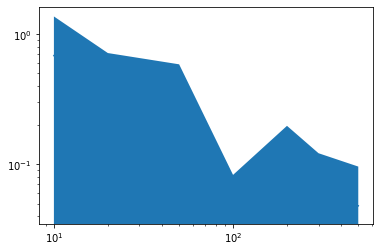

In [29]:
rel_error = np.abs((energies_different_meas_num - energy_brute) / energy_brute)
rel_error_mean = np.mean(rel_error, axis=1)
rel_error_std = np.mean(rel_error, axis=1)
plt.plot(num_of_measurements, rel_error_mean)
plt.fill_between(num_of_measurements, rel_error_mean - rel_error_std, rel_error_mean + rel_error_std)
plt.yscale('log')
plt.xscale('log')

In [11]:
# now we have a method to keep only the unique indices, now we convert the measurements to the necessary shape for shadow prediction
batches = 10
num_of_measurements = np.array([10, 20, 50, 100, 200, 300, 500])
num_of_measurements_per_rot = 50
energies_different_meas_num = np.zeros((np.size(num_of_measurements), batches))
for b in range(batches):
    for i in range(np.size(num_of_measurements)):
        meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, tensor_liste).measurement_shadow(num_of_measurements[i], num_of_measurements_per_rot)
        energies = np.zeros(len(meas_outcomes))
        for n in range(len(meas_outcomes)):
            # first get the unique elements of this torch tensor
            unique_meas_outcomes, index_perm = np.unique(meas_outcomes[n].numpy(), return_index=True)
            probs_sorted = probs[n][index_perm]
            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(unique_meas_outcomes), unique_meas_outcomes, qubit_num)
            energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_sorted)
        energy = np.mean(energies)
        energies_different_meas_num[i,b] = energy

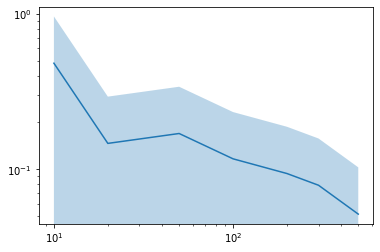

In [13]:
rel_error = np.abs((energies_different_meas_num - energy_brute) / energy_brute)
rel_error_mean = np.mean(rel_error, axis=1)
rel_error_std = np.mean(rel_error, axis=1)
plt.plot(num_of_measurements, rel_error_mean)
plt.fill_between(num_of_measurements, rel_error_mean - rel_error_std, rel_error_mean + rel_error_std, alpha=0.3)
plt.yscale('log')
plt.xscale('log')